In [ ]:
import scipy.io
import matplotlib.pyplot as plt
from scipy import *
from scipy.linalg import norm, pinv
from matplotlib import pyplot as plt
import numpy as np
import pyximport
from sklearn import preprocessing
pyximport.install()
from scipy.stats import zscore
!pip install rtree
!pip install seiscm
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker
from scipy import fftpack
import cv2
import warnings

warnings.filterwarnings("ignore")
from seiscm import seismic
from sklearn.neighbors import KNeighborsRegressor

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


In [3]:
def knn_sklearn(x_data, y_data, neighbors):
    neigh = KNeighborsRegressor(n_neighbors=neighbors)
    neigh.fit(x_data, y_data)
    return neigh

def cvNormalize(data):
    norm_image = cv2.normalize(data, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    # norm_image = norm_image.astype(np.uint8)
    return norm_image

def normalize_dg(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def omit_percent(percent, data):
    assert data.shape[1] > 2
    indices = np.random.choice(np.arange(data.shape[1]), replace=False,
                               size=int(data.shape[1] * (percent/100.)))
    # myarray[indices] = 0
    temp = np.ones(data.shape)
    temp[:,indices] = np.zeros((data.shape[0], 1))
    ret = np.multiply(data,temp)
    
    return ret, sorted(indices)

def omit_percent_reloaded(percent, data, previous_omit_percent):
    assert data.shape[1] > 2
    
    # myarray[indices] = 0
    indices = previous_omit_percent
    while len(list(set(indices) & set(previous_omit_percent))) > 0:
        indices = np.random.choice(np.arange(data.shape[1]), replace=False,
                               size=int(data.shape[1] * (percent/100.)))
    
    
    temp = np.ones(data.shape)
    temp[:,indices] = np.zeros((data.shape[0], 1))
    ret = np.multiply(data,temp)
    
    return ret, sorted(indices)

def calculate_psnr(img1, img2, max_value=1):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

def plot_dgs(dg, title, min_offset, max_offset, min_time, max_time, save_figure = True): #TODO: add arguments for min/max offset and time
    fig = plt.figure(figsize=(6,10))
    plt.imshow(dg, extent=[min_offset, max_offset, max_time, min_time], aspect='auto', cmap='gray')
    plt.xlabel("Offset")
    plt.ylabel("Time(s)")
    plt.title(title.replace("_"," "))
    if save_figure:
        fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/'+title+'.png', dpi=fig.dpi)

def plot_dgs_color(dg, title, x_offsets, y_time, save_figure = True):
    f, ax = plt.subplots(figsize=(6,10))
    pp = ax.pcolormesh(x_offsets, y_time, dg, cmap=seismic())
    f.colorbar(pp, orientation="vertical")
    plt.xlabel("Offset")
    plt.ylabel("Time(s)")
    plt.gca().invert_yaxis()
    plt.title(title.replace("_"," "))
    if save_figure:
        f.savefig('/content/gdrive/MyDrive/RBF/Picture_results/'+title+'_color.png', dpi=f.dpi)


def plot_ffts(data, title, save_figure = True):
    fig = plt.figure(figsize=(6,10))
    plt.imshow(data, aspect=0.1)
    plt.xlabel("Wave number")
    plt.ylabel("Frequency (Hz)")
    plt.title(title.replace("_"," "))
    if save_figure:
        fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/'+title+'.png', dpi=fig.dpi)

def makeSpectrum(E, dx, dy, upsample=10):
    """
    Convert a time-domain array `E` to the frequency domain via 2D FFT. `dx` and
    `dy` are sample spacing in x (left-right, 1st axis) and y (up-down, 0th
    axis) directions. An optional `upsample > 1` will zero-pad `E` to obtain an
    upsampled spectrum.

    Returns `(spectrum, xf, yf)` where `spectrum` contains the 2D FFT of `E`. If
    `Ny, Nx = spectrum.shape`, `xf` and `yf` will be vectors of length `Nx` and
    `Ny` respectively, containing the frequencies corresponding to each pixel of
    `spectrum`.

    The returned spectrum is zero-centered (via `fftshift`). The 2D FFT, and
    this function, assume your input `E` has its origin at the top-left of the
    array. If this is not the case, i.e., your input `E`'s origin is translated
    away from the first pixel, the returned `spectrum`'s phase will *not* match
    what you expect, since a translation in the time domain is a modulation of
    the frequency domain. (If you don't care about the spectrum's phase, i.e.,
    only magnitude, then you can ignore all these origin issues.)
    """
    zeropadded = np.array(E.shape) * upsample
    F = fft.fftshift(fft.fft2(E, zeropadded)) / E.size
    xf = fft.fftshift(fft.fftfreq(zeropadded[1], d=dx))
    yf = fft.fftshift(fft.fftfreq(zeropadded[0], d=dy))
    return (F, xf, yf)


def extents(f):
    "Convert a vector into the 2-element extents vector imshow needs"
    delta = f[1] - f[0]
    return [f[0] - delta / 2, f[-1] + delta / 2]


def plotSpectrum(F, xf, yf, title, save_figure = True):
    "Plot a spectrum array and vectors of x and y frequency spacings"
    fig = plt.figure()
    plt.imshow(abs(F),
               aspect="equal",
               interpolation="none",
               origin="lower",
               extent=extents(xf) + extents(yf))
    plt.colorbar()
    plt.xlabel('f_x (Hz)')
    plt.ylabel('f_y (Hz)')
    plt.title(title.replace("_"," "))
    plt.show()
    if save_figure:
        fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/'+title+'.png', dpi=fig.dpi)

def load_input_data(file_path):
    mat = scipy.io.loadmat(file_path)
    dg = mat['Dg']
    offset = mat['offset']
    t = mat['t']
    return dg, offset, t

def noisy(data):
    row,col = data.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = data + gauss
    return noisy

%mkdir /content/gdrive/MyDrive/RBF/Picture_results/

In [ ]:
%cd /content/gdrive/MyDrive/RBF
!python setup.py install

In [ ]:
dg, offset, t = load_input_data('/content/gdrive/MyDrive/Syn_shot1g.mat')
some_dg = cvNormalize(dg)
plot_dgs(dg, "Original_Synthetic_Seismic_Data", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=False)
X, Y = np.meshgrid(offset[0][:60], t[0])
plot_dgs_color(dg, "Original_Synthetic_Seismic_Data", X, Y, save_figure = True)
fft1 = np.fft.fft2(dg)
plot_ffts(abs(np.fft.fftshift(fft1)), "Original_Synthetic_Seismic_Data_2D_FFT_Amplitude_Spectrum", save_figure=False)

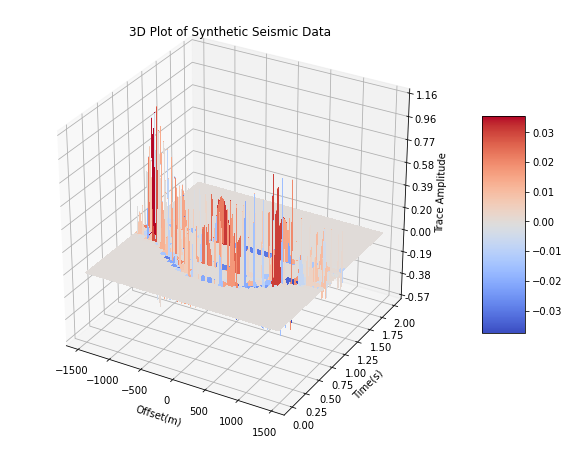

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
X, Y = np.meshgrid(offset[0][:60], t[0])

surf = ax.plot_surface(X, Y, dg, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.02f}'))

# # Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("3D Plot of Synthetic Seismic Data")
ax.set_xlabel('Offset(m)')
ax.set_ylabel('Time(s)')
ax.set_zlabel('Trace Amplitude')
fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/'+'3D_synthetic_data_plot.png', dpi=fig.dpi)
plt.show()

In [ ]:
# %cd /content/gdrive/MyDrive/RBF/test
# !python -m unittest discover

/content/gdrive/MyDrive/RBF/test
........................................................................................../usr/local/lib/python3.7/dist-packages/RBF-2021.5.15+7.g50e4b5d.dirty-py3.7-linux-x86_64.egg/rbf/linalg.py:581: UserWarning: Could not import CHOLMOD. Sparse matrices will be converted to dense for all Cholesky decompositions
  warnings.warn(CHOLMOD_MSG)
................
----------------------------------------------------------------------
Ran 106 tests in 594.766s

OK


In [8]:
%cd /content/gdrive/MyDrive/RBF/
import rbf
from rbf.interpolate import RBFInterpolant
from scipy import fftpack

def seismic_rbf_interpolation(percent, dg, plot = True):
    dg_1, omit_index = omit_percent(percent, dg)
    plot_dgs(dg_1, "Omited_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)

    ori_offset = offset[0][:60].reshape(1,60)
    # new_ori_offset = np.delete(ori_offset, omit_index, axis=1)
    # new_dg = np.delete(dg, omit_index, axis=1)
    ori_t = t
    U, V = np.meshgrid(ori_offset, ori_t)
    Y = dg.copy()
    combined = ori_offset.shape[1] * ori_t.shape[1]
    u_copy = (np.asarray(U.flatten())).reshape(combined,)
    v_copy = (np.asarray(V.flatten())).reshape(combined,)
    y_copy = (np.asarray(Y.flatten())).reshape(combined,)
    x = np.zeros([combined,2])
    # x = x.reshape([30060,2])
    x[:,0] = u_copy
    x[:,1] = v_copy

    I = RBFInterpolant(x, y_copy, sigma=0, phi='wen30', order=3)
    inter_offset = []
    for i, data in enumerate(ori_offset[0]):
        if i in omit_index:
            inter_offset.append(data)
    x1, x2 = (np.array(inter_offset)).reshape((1,len(inter_offset))), ori_t
    # x1, x2 = ori_offset, ori_t
    x_itp = np.reshape(np.meshgrid(x1, x2), (2, x1.shape[1]*x2.shape[1])).T
    y_itp = I(x_itp)
    y_itp = y_itp.reshape((x2.shape[1],x1.shape[1]))
    # y_itp = cvNormalize(y_itp)
    # y_itp = np.min(dg) + ((np.max(dg) - np.min(dg)) / (np.max(y_itp) - np.min(y_itp))) * (y_itp - np.min(y_itp))
    # y_itp = normalize_dg(y_itp)


    # x1_1, x2_1 = ori_offset, ori_t
    # x_itp_1 = np.reshape(np.meshgrid(x1_1, x2_1), (2, x1_1.shape[1]*x2_1.shape[1])).T
    # y_itp_1 = I(x_itp_1)
    # y_itp_1 = y_itp_1.reshape((x2_1.shape[1],x1_1.shape[1]))

    # temp = np.ones(y_itp_1.shape)
    # temp[:,omit_index] = np.zeros((y_itp_1.shape[0], 1))
    # y_itp_1 = np.multiply(y_itp_1,temp)

    old_data = np.zeros((x2.shape[1],x1.shape[1]))
    n = 0
    for i in omit_index:
        old_data[:,n] = dg[:,i]
        n += 1

    # plt.figure(figsize=(15,10))
    # plt.subplot(1,2,1)
    # plt.imshow(y_itp, extent=[-1475,1475,2,0], aspect='auto', cmap='gray')
    # plt.subplot(1,2,2)
    # plt.imshow(old_data, extent=[-1475,1475,2,0], aspect='auto', cmap='gray')
    # plt.show()

    k = 0
    tempi = dg.copy()
    for i in omit_index:
        tempi[:,i] = y_itp[:,k]
        k += 1
    
    plot_dgs(tempi, "Interpolated_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)
    plot_dgs(dg - tempi, "Subtracted_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)

    fft2 = np.fft.fft2(tempi)

    plot_ffts(abs(np.fft.fftshift(fft2)), "Amplitude_Spectrum_of_Interpolated_Traces_at_"+str(percent)+"_Percent")

    return calculate_psnr(tempi, dg, max_value=np.max(dg))


/content/gdrive/MyDrive/RBF


In [ ]:
# seismic_rbf_interpolation(20, dg, plot= False)

In [ ]:
peak_snr_list_1 = []
traces_percent_remal_list = list(range(10,91,10))
for i in traces_percent_remal_list:
    psnr = seismic_rbf_interpolation(i, dg)
    peak_snr_list_1.append(psnr)

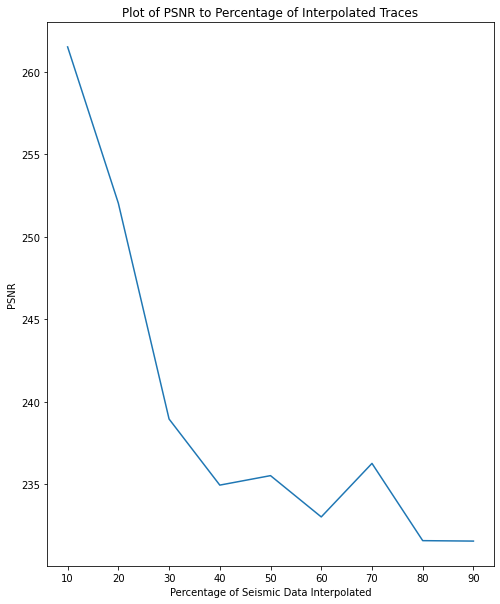

In [ ]:
fig = plt.figure(figsize=(8,10))
plt.plot(traces_percent_remal_list, peak_snr_list_1)
plt.xlabel("Percentage of Seismic Data Interpolated")
plt.ylabel("PSNR")
plt.title("Plot of PSNR to Percentage of Interpolated Traces")
plt.show()
fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/psnr_vs_inter_percent.png', dpi=fig.dpi)

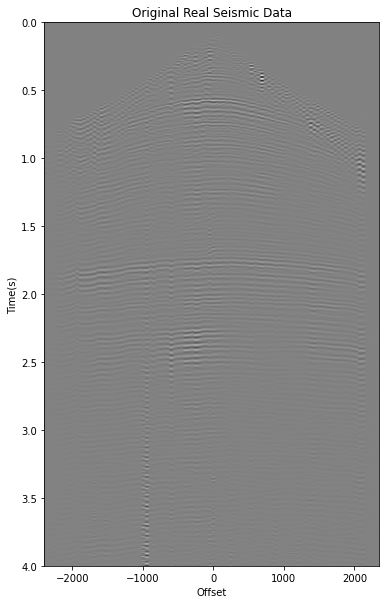

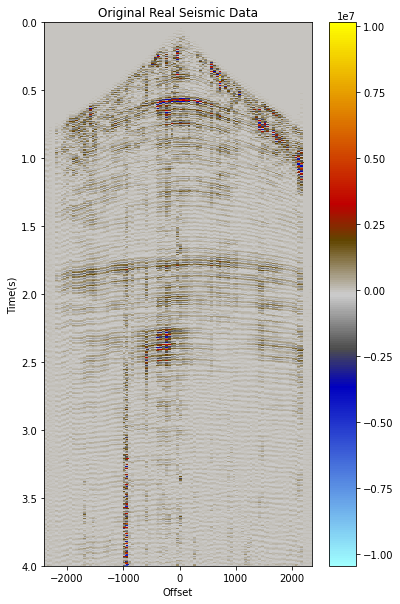

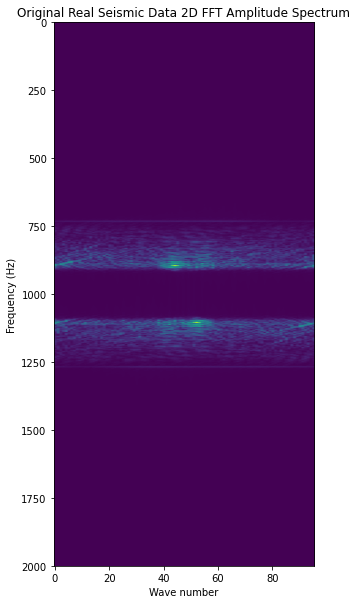

In [ ]:
dg_real, offset_real, t_real = load_input_data('/content/gdrive/MyDrive/Yilmaz_25g_BPF.mat')
plot_dgs(dg_real, "Original_Real_Seismic_Data", np.min(offset_real), np.max(offset_real), np.min(t_real), np.max(t_real), save_figure=False)
X, Y = np.meshgrid(offset_real, t_real)
plot_dgs_color(dg_real, "Original_Real_Seismic_Data", X, Y, save_figure = True)
fft_real = np.fft.fft2(dg_real)
plot_ffts(abs(np.fft.fftshift(fft_real)), "Original_Real_Seismic_Data_2D_FFT_Amplitude_Spectrum")

In [ ]:
%cd /content/gdrive/MyDrive/RBF/
import rbf
from rbf.interpolate import RBFInterpolant
import math


def splice_before_interpolation(percent, dg, offset, time, slices = 4):
    dg_1, omit_index = omit_percent(percent, dg)
    plot_dgs(dg_1, "Omited_Traces_at_"+str(percent)+"_Percent_Real_Data", np.min(offset_real), np.max(offset_real), np.min(t_real), np.max(t_real))

    divs = math.ceil(time.shape[1]/slices)
    slices = math.ceil(2001/divs)
    k = 0
    final_y_itp = np.zeros((time.shape[1], len(omit_index)))

    for slice_ in range(slices):
        dg_slices = dg[k:k+divs, :]
        time_slices = time[:,k:k+divs]
    
        ori_offset = offset
        ori_t = time_slices
        U, V = np.meshgrid(ori_offset, ori_t)
        Y = dg_slices.copy()
        combined = ori_offset.shape[1] * time_slices.shape[1]
        u_copy = (np.asarray(U.flatten())).reshape(combined,)
        v_copy = (np.asarray(V.flatten())).reshape(combined,)
        y_copy = (np.asarray(Y.flatten())).reshape(combined,)
        x = np.zeros([combined,2])
        x[:,0] = u_copy
        x[:,1] = v_copy

        I = RBFInterpolant(x, y_copy, sigma=0, phi='wen30', order=3)
        inter_offset = []
        for i, data in enumerate(ori_offset[0]):
            if i in omit_index:
                inter_offset.append(data)
        x1, x2 = (np.array(inter_offset)).reshape((1,len(inter_offset))), ori_t
        x_itp = np.reshape(np.meshgrid(x1, x2), (2, x1.shape[1]*x2.shape[1])).T
        y_itp = I(x_itp)
        y_itp = y_itp.reshape((x2.shape[1],x1.shape[1]))
        # y_itp = np.min(dg_slices) + ((np.max(dg_slices) - np.min(dg_slices)) / (np.max(y_itp) - np.min(y_itp))) * (y_itp - np.min(y_itp))

        final_y_itp[k:k+divs, :] = y_itp
        # print("Done with step", slice_)
        # print(np.sum(final_y_itp))
        # print("*"*10)
        k+=divs

        # if i == 0:
        #     final_y_itp = y_itp
        # else:
        #     print(final_y_itp.shape)
        #     print(y_itp.shape)
        #     final_y_itp = np.vstack((final_y_itp, y_itp))

    k = 0
    tempi = dg.copy()
    for ind in omit_index:
        tempi[:,ind] = final_y_itp[:,k]
        k += 1
    
    plot_dgs(tempi, "Interpolated_Traces_at_"+str(percent)+"_Percent_Real", np.min(offset_real), np.max(offset_real), np.min(t_real), np.max(t_real))
    plot_dgs(dg - tempi, "Subtracted_Traces_at_"+str(percent)+"_Percent_Real", np.min(offset_real), np.max(offset_real), np.min(t_real), np.max(t_real))

    fft2 = np.fft.fft2(tempi)

    plot_ffts(abs(np.fft.fftshift(fft2)), "Amplitude_Spectrum_of_Interpolated_Traces_at_"+str(percent)+"_Percent_Real")
    
    # spectrum, xf, yf = makeSpectrum(tempi, offset_real[:,2] - offset_real[:,1], t_real[:,2] - t_real[:,1])
    # plotSpectrum(spectrum, xf, yf, "Amplitude_Spectrum_of_Interpolated_Traces_at_"+str(percent)+"_Percent_Real")

    return calculate_psnr(tempi, dg, max_value=np.max(dg))

/content/gdrive/MyDrive/RBF


In [ ]:
# splice_before_interpolation(20, dg_real, offset_real, t_real, slices = 5.5)

In [ ]:
peak_snr_list_2 = []
traces_percent_remal_list = list(range(10,91,10))
for percent in traces_percent_remal_list:
    psnr = splice_before_interpolation(percent, dg_real, offset_real, t_real, slices = 5.5)
    peak_snr_list_2.append(psnr)

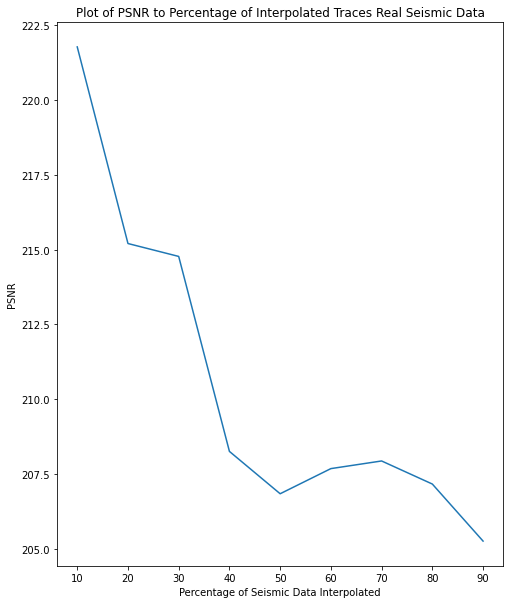

In [ ]:
fig = plt.figure(figsize=(8,10))
plt.plot(traces_percent_remal_list, peak_snr_list_2)
plt.xlabel("Percentage of Seismic Data Interpolated")
plt.ylabel("PSNR")
plt.title("Plot of PSNR to Percentage of Interpolated Traces Real Seismic Data")
plt.show()
fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/psnr_vs_inter_percent_real_data.png', dpi=fig.dpi)

In [ ]:
from scipy.interpolate import NearestNDInterpolator
def knn_rbf_interpolation(percent, dg, plot = True):
    dg_1, omit_index = omit_percent(percent, dg)
    # plot_dgs(dg_1, "Omited_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)

    ori_offset = offset[0][:60].reshape(1,60)
    new_ori_offset = np.delete(ori_offset, omit_index, axis=1)
    new_dg = np.delete(dg, omit_index, axis=1)
    ori_t = t
    U, V = np.meshgrid(new_ori_offset, ori_t)
    Y = new_dg.copy()
    combined = new_ori_offset.shape[1] * ori_t.shape[1]
    u_copy = (np.asarray(U.flatten())).reshape(combined,)
    v_copy = (np.asarray(V.flatten())).reshape(combined,)
    y_copy = (np.asarray(Y.flatten())).reshape(combined,)
    x = np.zeros([combined,2])
    # x = x.reshape([30060,2])
    x[:,0] = u_copy
    x[:,1] = v_copy

    # scaler = StandardScaler()
    # scaler.fit(x)
    # x = scaler.transform(x)

    # model = knn_sklearn(x, y_copy, neighbors)
    interp = NearestNDInterpolator(x, y_copy)
    # RBFInterpolant(x, y_copy, sigma=0.1, phi='wen30', order=1)
    inter_offset = []
    for i, data in enumerate(ori_offset[0]):
        if i in omit_index:
            inter_offset.append(data)
    x1, x2 = (np.array(inter_offset)).reshape((1,len(inter_offset))), ori_t
    # x1, x2 = ori_offset, ori_t
    x1_, x2_ = np.meshgrid(x1, x2)
    
    # combined_ = new_ori_offset.shape[1] * ori_t.shape[1]
    # u_copy = (np.asarray(U.flatten())).reshape(combined,)
    # v_copy = (np.asarray(V.flatten())).reshape(combined,)
    x_itp = np.reshape(np.meshgrid(x1, x2), (x1.shape[1]*x2.shape[1], 2))
    # scaler.fit(x_itp)
    # x_itp = scaler.transform(x_itp)
    # y_itp = I(x_itp)
    # y_itp = model.predict(x_itp)
    y_itp = interp(x1_, x2_)
    y_itp = y_itp.reshape((x2.shape[1], x1.shape[1]))
    # y_itp = cvNormalize(y_itp)
    # y_itp = np.min(dg) + ((np.max(dg) - np.min(dg)) / (np.max(y_itp) - np.min(y_itp))) * (y_itp - np.min(y_itp))
    # y_itp = normalize_dg(y_itp)


    # x1_1, x2_1 = ori_offset, ori_t
    # x_itp_1 = np.reshape(np.meshgrid(x1_1, x2_1), (2, x1_1.shape[1]*x2_1.shape[1])).T
    # y_itp_1 = I(x_itp_1)
    # y_itp_1 = y_itp_1.reshape((x2_1.shape[1],x1_1.shape[1]))

    # temp = np.ones(y_itp_1.shape)
    # temp[:,omit_index] = np.zeros((y_itp_1.shape[0], 1))
    # y_itp_1 = np.multiply(y_itp_1,temp)

    old_data = np.zeros((x2.shape[1],x1.shape[1]))
    n = 0
    for i in omit_index:
        old_data[:,n] = dg[:,i]
        n += 1

    # plt.figure(figsize=(15,10))
    # plt.subplot(1,2,1)
    # plt.imshow(y_itp, extent=[-1475,1475,2,0], aspect='auto', cmap='gray')
    # plt.subplot(1,2,2)
    # plt.imshow(old_data, extent=[-1475,1475,2,0], aspect='auto', cmap='gray')
    # plt.show()

    k = 0
    tempi = dg.copy()
    for i in omit_index:
        tempi[:,i] = y_itp[:,k]
        k += 1
    
    plot_dgs(tempi, "KNN_Interpolated_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)
    plot_dgs(dg - tempi, "KNN_Subtracted_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)

    fft2 = np.fft.fft2(tempi)

    plot_ffts(abs(np.fft.fftshift(fft2)), "KNN_Amplitude_Spectrum_of_Interpolated_Traces_at_"+str(percent)+"_Percent")

    return calculate_psnr(tempi, dg, max_value=np.max(dg))


In [ ]:
knn_rbf_interpolation(20, dg, plot= False)

In [ ]:
peak_snr_list_3 = []
traces_percent_remal_list = list(range(10,91,10))
for percent in traces_percent_remal_list:
    psnr = knn_rbf_interpolation(percent, dg, plot= True)
    peak_snr_list_3.append(psnr)

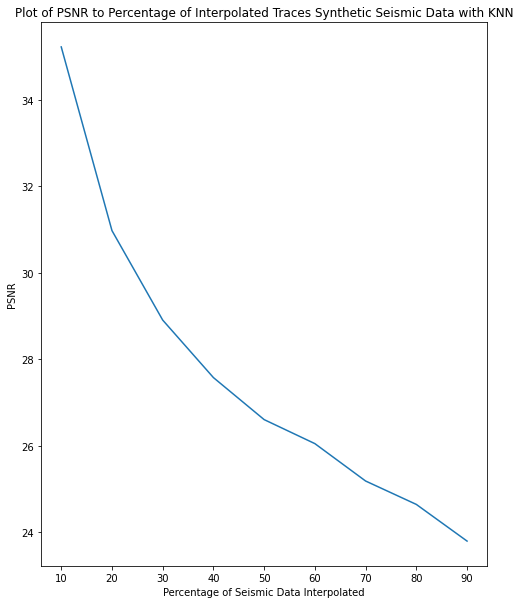

In [ ]:
fig = plt.figure(figsize=(8,10))
plt.plot(traces_percent_remal_list, peak_snr_list_3)
plt.xlabel("Percentage of Seismic Data Interpolated")
plt.ylabel("PSNR")
plt.title("Plot of PSNR to Percentage of Interpolated Traces Synthetic Seismic Data with KNN")
plt.show()
fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/knn_psnr_vs_inter_percent_synthetic_data.png', dpi=fig.dpi)

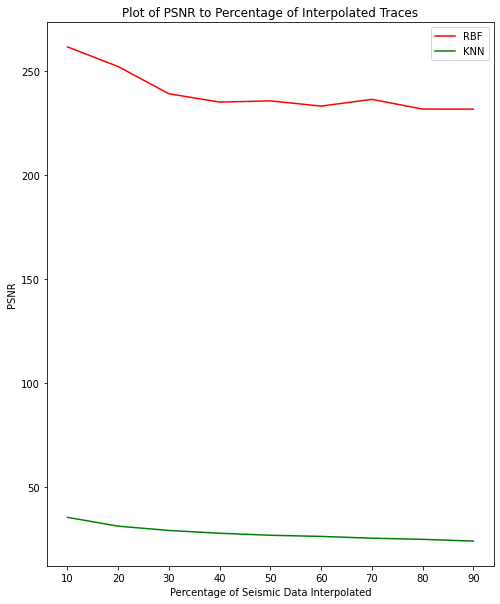

In [ ]:
fig = plt.figure(figsize=(8,10))
plt.plot(traces_percent_remal_list, peak_snr_list_1, c ='red', label='RBF')
plt.plot(traces_percent_remal_list, peak_snr_list_3, c ='green', label='KNN')
plt.legend(loc='upper right')
plt.xlabel("Percentage of Seismic Data Interpolated")
plt.ylabel("PSNR")
plt.title("Plot of PSNR to Percentage of Interpolated Traces")
plt.show()
fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/psnr_vs_inter_percent_knn_rbf.png', dpi=fig.dpi)

In [ ]:
from scipy.interpolate import NearestNDInterpolator
def knn_rbf_interpolation_real(percent, dg, offset, time, plot = True):
    dg_1, omit_index = omit_percent(percent, dg)
    # plot_dgs(dg_1, "Omited_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)

    ori_offset = offset
    new_ori_offset = np.delete(ori_offset, omit_index, axis=1)
    new_dg = np.delete(dg, omit_index, axis=1)
    ori_t = time
    U, V = np.meshgrid(new_ori_offset, ori_t)
    Y = new_dg.copy()
    combined = new_ori_offset.shape[1] * ori_t.shape[1]
    u_copy = (np.asarray(U.flatten())).reshape(combined,)
    v_copy = (np.asarray(V.flatten())).reshape(combined,)
    y_copy = (np.asarray(Y.flatten())).reshape(combined,)
    x = np.zeros([combined,2])
    # x = x.reshape([30060,2])
    x[:,0] = u_copy
    x[:,1] = v_copy

    # scaler = StandardScaler()
    # scaler.fit(x)
    # x = scaler.transform(x)

    # model = knn_sklearn(x, y_copy, neighbors)
    interp = NearestNDInterpolator(x, y_copy)
    # RBFInterpolant(x, y_copy, sigma=0.1, phi='wen30', order=1)
    inter_offset = []
    for i, data in enumerate(ori_offset[0]):
        if i in omit_index:
            inter_offset.append(data)
    x1, x2 = (np.array(inter_offset)).reshape((1,len(inter_offset))), ori_t
    # x1, x2 = ori_offset, ori_t
    x1_, x2_ = np.meshgrid(x1, x2)
    
    # combined_ = new_ori_offset.shape[1] * ori_t.shape[1]
    # u_copy = (np.asarray(U.flatten())).reshape(combined,)
    # v_copy = (np.asarray(V.flatten())).reshape(combined,)
    x_itp = np.reshape(np.meshgrid(x1, x2), (x1.shape[1]*x2.shape[1], 2))
    # scaler.fit(x_itp)
    # x_itp = scaler.transform(x_itp)
    # y_itp = I(x_itp)
    # y_itp = model.predict(x_itp)
    y_itp = interp(x1_, x2_)
    y_itp = y_itp.reshape((x2.shape[1], x1.shape[1]))
    # y_itp = cvNormalize(y_itp)
    # y_itp = np.min(dg) + ((np.max(dg) - np.min(dg)) / (np.max(y_itp) - np.min(y_itp))) * (y_itp - np.min(y_itp))
    # y_itp = normalize_dg(y_itp)


    # x1_1, x2_1 = ori_offset, ori_t
    # x_itp_1 = np.reshape(np.meshgrid(x1_1, x2_1), (2, x1_1.shape[1]*x2_1.shape[1])).T
    # y_itp_1 = I(x_itp_1)
    # y_itp_1 = y_itp_1.reshape((x2_1.shape[1],x1_1.shape[1]))

    # temp = np.ones(y_itp_1.shape)
    # temp[:,omit_index] = np.zeros((y_itp_1.shape[0], 1))
    # y_itp_1 = np.multiply(y_itp_1,temp)

    old_data = np.zeros((x2.shape[1],x1.shape[1]))
    n = 0
    for i in omit_index:
        old_data[:,n] = dg[:,i]
        n += 1

    # plt.figure(figsize=(15,10))
    # plt.subplot(1,2,1)
    # plt.imshow(y_itp, extent=[-1475,1475,2,0], aspect='auto', cmap='gray')
    # plt.subplot(1,2,2)
    # plt.imshow(old_data, extent=[-1475,1475,2,0], aspect='auto', cmap='gray')
    # plt.show()

    k = 0
    tempi = dg.copy()
    for i in omit_index:
        tempi[:,i] = y_itp[:,k]
        k += 1
    
    plot_dgs(tempi, "KNN_Interpolated_Traces_at_"+str(percent)+"_Percent_Real", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)
    plot_dgs(dg - tempi, "KNN_Subtracted_Traces_at_"+str(percent)+"_Percent_Real", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)

    fft2 = np.fft.fft2(tempi)

    plot_ffts(abs(np.fft.fftshift(fft2)), "KNN_Amplitude_Spectrum_of_Interpolated_Traces_at_"+str(percent)+"_Percent_Real")

    return calculate_psnr(tempi, dg, max_value=np.max(dg))


In [ ]:
knn_rbf_interpolation_real(20, dg_real, offset_real, t_real, plot = False)

In [ ]:
peak_snr_list_4 = []
traces_percent_remal_list = list(range(10,91,10))
for percent in traces_percent_remal_list:
    psnr = knn_rbf_interpolation_real(percent, dg_real, offset_real, t_real, plot = True)
    peak_snr_list_4.append(psnr)

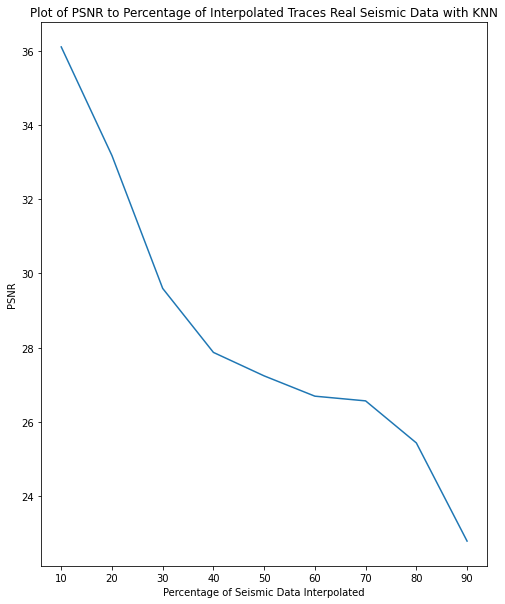

In [ ]:
fig = plt.figure(figsize=(8,10))
plt.plot(traces_percent_remal_list, peak_snr_list_4)
plt.xlabel("Percentage of Seismic Data Interpolated")
plt.ylabel("PSNR")
plt.title("Plot of PSNR to Percentage of Interpolated Traces Real Seismic Data with KNN")
plt.show()
fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/knn_psnr_vs_inter_percent_synthetic_data_real.png', dpi=fig.dpi)

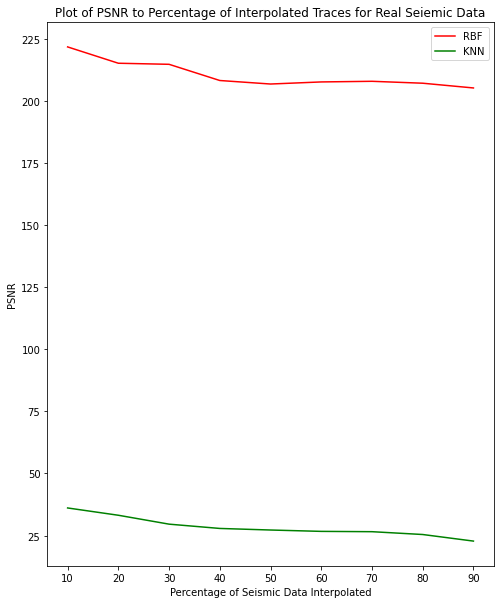

In [ ]:
fig = plt.figure(figsize=(8,10))
plt.plot(traces_percent_remal_list, peak_snr_list_2, c ='red', label='RBF')
plt.plot(traces_percent_remal_list, peak_snr_list_4, c ='green', label='KNN')
plt.legend(loc='upper right')
plt.xlabel("Percentage of Seismic Data Interpolated")
plt.ylabel("PSNR")
plt.title("Plot of PSNR to Percentage of Interpolated Traces for Real Seiemic Data")
plt.show()
fig.savefig('/content/gdrive/MyDrive/RBF/Picture_results/psnr_vs_inter_percent_knn_rbf_real.png', dpi=fig.dpi)

In [ ]:
def add_noise_to_dg_noisy(percent, dg, plot = True):
    dg_1, omit_index = omit_percent(percent, dg)

    ori_offset = offset[0][:dg.shape[1]].reshape(1,dg.shape[1])
    percent_dg = dg[:,omit_index]
    noisy_part = noisy(percent_dg)
    k = 0
    for i in omit_index:
        dg_1[:,i] = noisy_part[:,k]
        k += 1
    plot_dgs(dg_1, "Added_Noise_To_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)
    return dg_1, omit_index

In [ ]:
%cd /content/gdrive/MyDrive/RBF/
import rbf
from rbf.interpolate import RBFInterpolant
from scipy import fftpack

def seismic_rbf_interpolation_noisy(noise_percent, percent, dg, plot = True):
    noisy_dg_res, noisy_location = add_noise_to_dg_noisy(noise_percent, dg, plot = plot)
    dg_1, omit_index = omit_percent_reloaded(percent, noisy_dg_res, noisy_location)
    # dg_1, omit_index = omit_percent(percent, noisy_dg_res)
    plot_dgs(dg_1, "Added_Noise_Omited_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)

    ori_offset = offset[0][:60].reshape(1,60)
    new_ori_offset = np.delete(ori_offset, omit_index, axis=1)
    new_dg = np.delete(dg, omit_index, axis=1)
    ori_t = t
    U, V = np.meshgrid(new_ori_offset, ori_t)
    Y = new_dg.copy()
    combined = new_ori_offset.shape[1] * ori_t.shape[1]
    u_copy = (np.asarray(U.flatten())).reshape(combined,)
    v_copy = (np.asarray(V.flatten())).reshape(combined,)
    y_copy = (np.asarray(Y.flatten())).reshape(combined,)
    x = np.zeros([combined,2])
    # x = x.reshape([30060,2])
    x[:,0] = u_copy
    x[:,1] = v_copy

    I = RBFInterpolant(x, y_copy, sigma=0, phi='wen30', order=3)
    inter_offset = []
    for i, data in enumerate(ori_offset[0]):
        if i in omit_index:
            inter_offset.append(data)
    x1, x2 = (np.array(inter_offset)).reshape((1,len(inter_offset))), ori_t
    # x1, x2 = ori_offset, ori_t
    x_itp = np.reshape(np.meshgrid(x1, x2), (2, x1.shape[1]*x2.shape[1])).T
    y_itp = I(x_itp)
    y_itp = y_itp.reshape((x2.shape[1],x1.shape[1]))
    # y_itp = cvNormalize(y_itp)
    # y_itp = np.min(dg) + ((np.max(dg) - np.min(dg)) / (np.max(y_itp) - np.min(y_itp))) * (y_itp - np.min(y_itp))
    # y_itp = normalize_dg(y_itp)


    # x1_1, x2_1 = ori_offset, ori_t
    # x_itp_1 = np.reshape(np.meshgrid(x1_1, x2_1), (2, x1_1.shape[1]*x2_1.shape[1])).T
    # y_itp_1 = I(x_itp_1)
    # y_itp_1 = y_itp_1.reshape((x2_1.shape[1],x1_1.shape[1]))

    # temp = np.ones(y_itp_1.shape)
    # temp[:,omit_index] = np.zeros((y_itp_1.shape[0], 1))
    # y_itp_1 = np.multiply(y_itp_1,temp)

    old_data = np.zeros((x2.shape[1],x1.shape[1]))
    n = 0
    for i in omit_index:
        old_data[:,n] = dg[:,i]
        n += 1

    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(y_itp, extent=[-1475,1475,2,0], aspect='auto', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(old_data, extent=[-1475,1475,2,0], aspect='auto', cmap='gray')
    plt.show()

    k = 0
    tempi = dg.copy()
    for i in omit_index:
        tempi[:,i] = y_itp[:,k]
        k += 1
    
    plot_dgs(tempi, "Interpolated_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)
    plot_dgs(dg - tempi, "Subtracted_Traces_at_"+str(percent)+"_Percent", np.min(offset), np.max(offset), np.min(t), np.max(t), save_figure=plot)

    fft2 = np.fft.fft2(tempi)

    plot_ffts(abs(np.fft.fftshift(fft2)), "Amplitude_Spectrum_of_Interpolated_Traces_at_"+str(percent)+"_Percent", save_figure=plot)

    return calculate_psnr(tempi, dg, max_value=np.max(dg))

/content/gdrive/MyDrive/RBF


In [ ]:
seismic_rbf_interpolation_noisy(10, 20, dg, plot = False)

In [ ]:
# noiseSigma = 0.05 * dg
# noise = np.multiply(noiseSigma, randn(1, length(dg))
# noisySignal = dg + noise
def noisy(data):
    row,col= data.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = data + gauss
    return noisy

# plot_dgs(noisySignal, "Original_Synthetic_Seismic_Data", np.min(offset), np.max(offset), np.min(t), np.max(t), )

In [ ]:
import math
slices = 6
divs = math.ceil(2001/slices)
slices = math.ceil(2001/divs)

print(slices)

j = 0
for i in range(slices):
    print(range(j, j+divs))
    j += divs

6
range(0, 334)
range(334, 668)
range(668, 1002)
range(1002, 1336)
range(1336, 1670)
range(1670, 2004)


In [ ]:

# Class rbf_network
# A basic RBF network
class RbfNetwork:

    # Create object
    def __init__(self):

        # Reset
        # self.reset()

        # Reset network
        # def reset(self):

        # Reset network
        self.dim = None
        self.basis = None
        self.normalize = None
        self.n_basis = None
        self.centers_x = None
        self.centers_y = None
        self.weights = None
        self.betas = None
        self.x_max = None
        self.n_grid = None
        self.trained = False
        self.to_date = False
        self.rbf_file = None
        self.dataset_file = None
        self.dataset_inp = np.array([])
        self.dataset_out = np.array([])
        self.dataset_size = 0

    # Set network from input
    def set_rbf(self, *args, **kwargs):

        # Handle arguments
        self.n_basis = kwargs.get('n_basis', 5)
        self.basis = kwargs.get('basis', 'gaussian')
        self.normalize = kwargs.get('normalize', False)
        self.dim = kwargs.get('dim', 2)
        self.x_max = kwargs.get('x_max', 1.0)
        self.n_grid = kwargs.get('n_grid', 100)

        self.centers_x = kwargs.get('centers_x', None)
        self.centers_y = kwargs.get('centers_y', None)
        self.weights = kwargs.get('weights', None)
        self.betas = kwargs.get('betas', None)
        self.rbf_file = kwargs.get('rbf_file', None)

    # Set dataset from input
    def set_dataset(self, *args, **kwargs):

        # Handle arguments
        self.dim = kwargs.get('dim', 2)

        self.dataset_file = kwargs.get('dataset_file', None)
        self.dataset_inp = kwargs.get('dataset_inp', np.array([]))
        self.dataset_out = kwargs.get('dataset_out', np.array([]))
        self.dataset_size = kwargs.get('dataset_size', 0)

    # Rbf function
    def rbf(self, x, c, beta):

        # Compute radius
        r = np.linalg.norm(x - c)

        # Select rbf function
        if self.basis == 'gaussian':
            return np.exp(-beta * r ** 2)
        if self.basis == 'inv_mult':
            return np.sqrt(1.0 / (1.0 + beta * r ** 2))

    # Compute centers
    def compute_centers(self):

        # Select centers in the dataset
        # As of now, it is assumed that dataset size
        # is equal to nb of basis functions
        args = np.arange(self.n_basis)

        # Set centers
        self.centers_x = self.dataset_inp[args, :]
        self.centers_y = self.dataset_out[args]

    # Compute betas
    def compute_betas(self):

        # Initialize array
        dist = np.zeros([self.n_basis, self.n_basis])

        # For each center, compute all distances
        for i in range(self.n_basis):
            for j in range(self.n_basis):
                a = self.centers_x[i, :]
                b = self.centers_x[j, :]
                dist[i, j] = np.linalg.norm(a - b)

        # Find closest neighbor for each center
        self.betas = np.zeros([self.n_basis])

        for i in range(self.n_basis):
            sigma = np.max(dist[i, :])
            self.betas[i] = 1.0 / (sigma ** 2)

    # Compute weights
    def compute_weights(self):

        # Generate matrix using centers vector
        matrix = self.compute_matrix(self.centers_x)

        # Solve resulting pseudo-linear system
        inv = np.linalg.pinv(matrix,
                             rcond=1e-15)
        self.weights = np.dot(inv, self.centers_y)

    # Compute interpolation matrix
    def compute_matrix(self, x):

        # Interpolation matrix
        matrix = np.zeros([len(x), self.n_basis])

        for i in range(len(x)):
            for j in range(self.n_basis):
                matrix[i, j] = self.rbf(x[i],
                                        self.centers_x[j],
                                        self.betas[j])

        # Normalize if required
        if self.normalize:
            for i in range(len(x)):
                norm = np.sum(matrix[i, :])
                matrix[i, :] /= norm

        return matrix

    # Add data to the dataset
    # (x,y) should be a pair of (input,output)
    def add_data(self, x, y):

        # Stack into arrays
        if self.dataset_size == 0:
            self.dataset_inp = x
            self.dataset_out = y
        else:
            self.dataset_inp = np.vstack((self.dataset_inp, x))
            self.dataset_out = np.vstack((self.dataset_out, y))
        self.dataset_size += 1

        # Training is not to date
        self.to_date = False

    # Drop dataset
    def drop_dataset(self):

        # Set filename
        filename = 'dataset_' + str(self.n_basis) + '.dat'
        self.dataset_file = filename

        # Write dataset to file
        with open(filename, 'w') as f:
            f.write('{} '.format(self.dataset_size))
            f.write('{} '.format(self.dim))
            f.write('\n')
            for i in range(self.dataset_size):
                for j in range(self.dim):
                    f.write('{} '.format(self.dataset_inp[i, j]))
                f.write('{} '.format(float(self.dataset_out[i])))
                f.write('\n')

    # Read dataset
    def read_dataset(self,
                     filename):

        # Read header
        with open(filename) as f:
            line = f.read().split('\n')[0]
            line = line.rstrip()
            line = line.split(' ')

        # Read baseline info
        dataset_size = int(line[0])
        dim = int(line[1])

        # Allocate arrays
        dataset_inp = np.zeros([dataset_size, dim])
        dataset_out = np.zeros([dataset_size])

        # Read dataset
        with open(filename) as f:
            content = f.read().split('\n')
            for i in range(1, dataset_size + 1):
                j = i - 1
                line = content[i]
                line = line.rstrip()
                line = line.split(' ')

                for k in range(dim):
                    dataset_inp[j, k] = float(line[k])
                dataset_out[j] = float(line[dim + 0])

        # Set network
        self.set_dataset(dataset_size=dataset_size,
                         dim=dim,
                         dataset_inp=dataset_inp,
                         dataset_out=dataset_out,
                         dataset_file=filename)

    # Drop rbf
    def drop_rbf(self):

        # Set filename
        filename = 'rbf_' + str(self.n_basis) + '_' + str(self.basis) + '.dat'
        self.rbf_file = filename

        # Write file
        with open(filename, 'w') as f:
            f.write('{} '.format(self.n_basis))
            f.write('{} '.format(self.basis))
            f.write('{} '.format(self.normalize))
            f.write('{} '.format(self.dim))
            f.write('{} '.format(self.x_max))
            # f.write('{} '.format(self.offset))
            f.write('{} '.format(self.n_grid))
            f.write('\n')
            for i in range(self.n_basis):
                for k in range(self.dim):
                    f.write('{} '.format(float(self.centers_x[i, k])))
                f.write('{} '.format(float(self.centers_y[i])))
                f.write('{} '.format(float(self.weights[i])))
                f.write('{} '.format(float(self.betas[i])))
                f.write('\n')

    # Read rbf
    def read_rbf(self,
                 filename):

        # Read header
        with open(filename) as f:
            line = f.read().split('\n')[0]
            line = line.rstrip()
            line = line.split(' ')

        # Read baseline info
        n_basis = int(line[0])
        basis = line[1]
        normalize = True if (line[2] == 'True') else False
        dim = int(line[3])
        x_max = float(line[4])
        n_grid = float(line[5])

        # Allocate arrays
        centers_x = np.zeros([n_basis, dim])
        centers_y = np.zeros([n_basis])
        weights = np.zeros([n_basis])
        betas = np.zeros([n_basis])

        # Read centers, weights and betas
        with open(filename) as f:
            content = f.read().split('\n')
            for i in range(n_basis):
                line = content[i + 1]
                line = line.rstrip()
                line = line.split(' ')

                for k in range(dim):
                    centers_x[i, k] = float(line[k])
                centers_y[i] = float(line[dim + 0])
                weights[i] = float(line[dim + 1])
                betas[i] = float(line[dim + 2])

        # Set network
        self.set_rbf(n_basis=n_basis,
                     basis=basis,
                     normalize=normalize,
                     dim=dim,
                     x_max=x_max,
                     offset=offset,
                     n_grid=n_grid,
                     centers_x=centers_x,
                     centers_y=centers_y,
                     weights=weights,
                     betas=betas,
                     rbf_file=filename)

        self.trained = True

    # Train network
    def train(self):

        # Compute centers and weights
        # self.compute_centers()
        # self.compute_betas()
        self.compute_weights()

        # Mark as trained and to date
        self.trained = True
        self.to_date = True
        print("Done Training")

    # Predict once network is trained
    def predict(self, x):

        # Compute matrix and make prediction
        matrix = self.compute_matrix(x)
        y = np.dot(matrix, self.weights)

        return y

In [ ]:
basis = 'gaussian'  # 'gaussian' or 'inv_mult'
normalize = True  # normalized rbf if true
dim = 2  # input dimension (1 or 2)
n_basis = 30060  # nb of rbf functions to use
x_max = 5.0  # bounds for function to fit

In [ ]:
# network = RbfNetwork()
# network.set_rbf(n_basis=n_basis,
#                 basis=basis,
#                 normalize=normalize,
#                 x_max=x_max,
#                 dim=dim)

# # Fill dataset
# for i in range(n_basis):
#     network.add_data(x[i, :], y_copy[i])

# Train network
# network.train()
# network.drop_rbf()

In [ ]:
def drop_rbf(network):

        # Set filename
        filename = 'rbf_' + str(network.n_basis) + '_' + str(network.basis) + '.dat'
        network.rbf_file = filename
        weights = np.zeros([n_basis])

        # Write file
        with open(filename, 'w') as f:
            f.write('{} '.format(network.n_basis))
            f.write('{} '.format(network.basis))
            f.write('{} '.format(network.normalize))
            f.write('{} '.format(network.dim))
            f.write('{} '.format(network.x_max))
            # f.write('{} '.format(self.offset))
            f.write('{} '.format(network.n_grid))
            f.write('\n')
            for i in range(network.n_basis):
                for k in range(network.dim):
                    f.write('{} '.format(float(network.centers_x[i, k])))
                f.write('{} '.format(float(network.centers_y[i])))
                f.write('{} '.format(float(weights[i])))
                f.write('{} '.format(float(network.betas[i])))
                f.write('\n')

In [ ]:
drop_rbf(network)

In [ ]:
name = "/content/gdrive/MyDrive/rbf_30060_gaussian.dat"
network1 = RbfNetwork()
network1.read_rbf(name)

In [ ]:
len(network1.centers_x)

30060

In [ ]:
network1.train()
network1.drop_rbf()

In [ ]:
x_predcit = np.array([])

y_net = np.reshape(network.predict(x_predcit), (n_grid ** dim,))

In [ ]:
read_mat = scipy.io.loadmat('rbf_30060_gaussian.dat')
read_mat